2-3 코드는 제안 발표의 코드이고, 2-1 코드는 원변수에 대하여 클러스터링을 하고 PCA를 통해서 얼마나 클러스터링이 잘 됐는지 시각화하였지만, 2-3 코드는 PCA로 차원을 축소하고 클러스터링을 진행하였다.

# 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from matplotlib import font_manager, rc
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 50대 남자 데이터 로드

In [2]:
data = pd.read_csv('C:/Users/hyunj/Desktop/데이터마이닝 코드/New_After_Preprocessing.csv', encoding='CP949')
data_man = data.loc[data['성별코드'] == 1]

data_man = data_man.loc[(data_man['연령대 코드(5세단위)'] == 11) | (data_man['연령대 코드(5세단위)'] == 12)]
data_man.drop(['성별코드', '요단백', '연령대 코드(5세단위)', '음주여부', '흡연상태'], axis=1, inplace = True)
data_man.reset_index(inplace = True, drop=True)    
columns = list(data_man.columns)

data_man

,수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,HDL 콜레스테롤,LDL 콜레스테롤,혈색소,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,BMI
0,138.0,88.0,94.0,223.0,328.0,46.0,111.0,16.6,1.0,29.0,54.0,24.0,25.39
1,130.0,80.0,102.0,158.0,193.0,41.0,79.0,14.8,0.7,21.0,19.0,20.0,24.22
2,165.0,100.0,97.0,192.0,69.0,79.0,99.0,15.4,0.9,24.0,10.0,46.0,27.68
3,140.0,80.0,93.0,256.0,148.0,46.0,180.0,16.0,1.1,20.0,22.0,23.0,25.95
4,136.0,86.0,98.0,209.0,100.0,39.0,150.0,14.0,1.0,28.0,32.0,19.0,23.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33692,125.0,70.0,116.0,184.0,114.0,49.0,112.0,16.9,1.0,20.0,10.0,21.0,19.59
33693,108.0,76.0,107.0,214.0,97.0,50.0,144.0,15.5,0.7,24.0,24.0,52.0,23.88
33694,116.0,72.0,103.0,276.0,75.0,75.0,180.0,13.4,0.9,40.0,44.0,25.0,22.49
33695,120.0,70.0,110.0,224.0,73.0,65.0,144.0,15.1,0.9,24.0,14.0,35.0,21.22


# 클러스터링

* 차원 축소(PCA)

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

scaled_data_man = StandardScaler().fit_transform(data_man)
scaled_data_man_df = pd.DataFrame(scaled_data_man, columns=data_man.columns)

pca = PCA(n_components=10)
pca_array = pca.fit_transform(scaled_data_man_df)
pca_df = pd.DataFrame(pca_array, index=scaled_data_man_df.index,
                      columns=[f"pca{num+1}" for num in range(pca_array.shape[1])])
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
print('singular value :', pca.singular_values_)
print('singular vector :\n', pca.components_.T)
# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(pca_array.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

[0.1993031  0.15696048 0.12398755 0.10575807 0.07768679 0.07369207
 0.06560663 0.06141055 0.05344686 0.04051914]
0.9583712527078718
singular value : [295.47743778 262.21797247 233.05388099 215.24052901 184.47643431
 179.6708765  169.52788573 164.01696957 153.01302909 133.22858228]
singular vector :
 [[ 0.32437359  0.00725992 -0.58225737  0.15180929  0.08903449 -0.07156426
   0.09645367  0.02161386  0.09896768 -0.02646728]
 [ 0.33569599  0.04087001 -0.56264407  0.14647632  0.14270383 -0.08737392
   0.02515934  0.05322074  0.13638515 -0.05384888]
 [ 0.17786351 -0.17199767 -0.05467708 -0.06818045 -0.33374742  0.76358795
  -0.02002984 -0.35454167  0.32380028 -0.02828884]
 [ 0.11791281  0.66764099  0.05181199 -0.06097229 -0.13825257  0.05597976
   0.11947585 -0.01270759  0.01715537  0.12775895]
 [ 0.30964305  0.00119952  0.04371173 -0.49166615 -0.28875738 -0.12049422
   0.01716399  0.41071216  0.21597812  0.5344426 ]
 [-0.16632191  0.2089191  -0.08312544  0.59323131 -0.09358024  0.31515777


,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,2.591017,0.199303,0.199303
pca2,2.040547,0.156960,0.356264
pca3,1.611886,0.123988,0.480251
pca4,1.374896,0.105758,0.586009
pca5,1.009958,0.077687,0.663696
pca6,0.958025,0.073692,0.737388
pca7,0.852911,0.065607,0.802995
pca8,0.798361,0.061411,0.864405
pca9,0.694830,0.053447,0.917852
pca10,0.526764,0.040519,0.958371


데이터마이닝 강의 중에서 고윳값이 1이 넘은 축을 선택한다고 배워 5개의 축까지를 사용

* 5개의 축만 사용하여 차원축소

In [4]:
pca2 = PCA(n_components=5)
data_pca2 = pca2.fit_transform(scaled_data_man_df)
data_pca_df = pd.DataFrame(data_pca2, columns = ['component 0', 'component 1', 'component 2', 'component 3', 'component 4'])

print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))
print('singular value :', pca2.explained_variance_)
print('singular vector :\n', pca2.components_.T)

[0.1993031  0.15696048 0.12398755 0.10575807 0.07768679]
0.6636959987600893
singular value : [2.59101722 2.0405468  1.61188602 1.37489569 1.0099583 ]
singular vector :
 [[ 0.32437359  0.00725992 -0.58225737  0.15180929  0.08903449]
 [ 0.33569599  0.04087001 -0.56264407  0.14647632  0.14270383]
 [ 0.17786351 -0.17199767 -0.05467708 -0.06818045 -0.33374742]
 [ 0.11791281  0.66764099  0.05181199 -0.06097229 -0.13825257]
 [ 0.30964305  0.00119952  0.04371173 -0.49166615 -0.28875738]
 [-0.16632191  0.2089191  -0.08312544  0.59323131 -0.09358024]
 [ 0.0669061   0.65109551  0.06684554 -0.0847181  -0.00603717]
 [ 0.26386871  0.13557483  0.06235183 -0.07385207  0.16338761]
 [ 0.06821694  0.07203255  0.14206774 -0.16578524  0.75890929]
 [ 0.32312605 -0.06094076  0.37569444  0.43966173  0.09338073]
 [ 0.41517103 -0.10191431  0.37571431  0.24218458  0.0575292 ]
 [ 0.36415652 -0.01467417  0.13759256  0.11743372 -0.3403249 ]
 [ 0.35336278 -0.1322513  -0.01161036 -0.2181993   0.13617414]]


* PCA 축 요인 확인하기 (PCA loading)

In [5]:
explanation_df = pd.DataFrame(pca2.components_.T, index=data_man.columns)
explanation_df

,0,1,2,3,4
수축기 혈압,0.324374,0.007260,-0.582257,0.151809,0.089034
이완기 혈압,0.335696,0.040870,-0.562644,0.146476,0.142704
식전혈당(공복혈당),0.177864,-0.171998,-0.054677,-0.068180,-0.333747
총 콜레스테롤,0.117913,0.667641,0.051812,-0.060972,-0.138253
트리글리세라이드,0.309643,0.001200,0.043712,-0.491666,-0.288757
HDL 콜레스테롤,-0.166322,0.208919,-0.083125,0.593231,-0.093580
LDL 콜레스테롤,0.066906,0.651096,0.066846,-0.084718,-0.006037
혈색소,0.263869,0.135575,0.062352,-0.073852,0.163388
혈청크레아티닌,0.068217,0.072033,0.142068,-0.165785,0.758909
(혈청지오티)AST,0.323126,-0.060941,0.375694,0.439662,0.093381


* 최적의 k 찾기 (Elbow Graph)

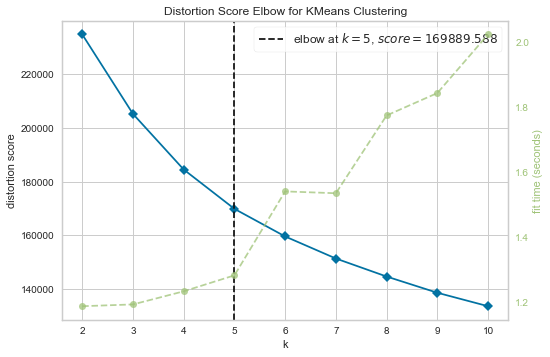

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=10)

visualizer.fit(data_pca_df)        # Fit the data to the visualizer
visualizer.show()

* K-Means 클러스터링

In [7]:
kmeans = KMeans(n_clusters=5, n_init=15, max_iter=300, random_state=0)

clusters = kmeans.fit_predict(pca_df)
centroids = kmeans.cluster_centers_

data_pca_df['cluster'] = clusters

# 검정

* 아노바 검정

In [8]:
from scipy import stats
group1 = data_pca_df.loc[data_pca_df['cluster'] == 0]
group2 = data_pca_df.loc[data_pca_df['cluster'] == 1]
group3 = data_pca_df.loc[data_pca_df['cluster'] == 2]
group4 = data_pca_df.loc[data_pca_df['cluster'] == 3]
group5 = data_pca_df.loc[data_pca_df['cluster'] == 4]

group1 = group1.values
group2 = group2.values
group3 = group3.values
group4 = group4.values
group5 = group5.values

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5)

print('데이터의 일원분산분석 결과 : F={} , p={}'.format(F_statistic, pVal))

데이터의 일원분산분석 결과 : F=[13295.32964494  8568.74132872  6020.05300711  2212.48798772
    21.70823509            inf] , p=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.53392405e-18 0.00000000e+00]


C:\Users\hyunj\Anaconda3\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


* PCA 후 2차원 시각화

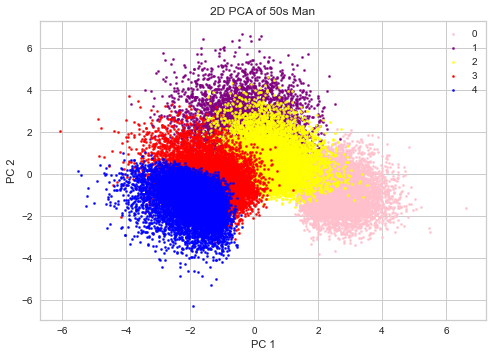

In [9]:
temp_data = data_pca_df.drop('cluster', axis = 1)
scaled_data_pca = StandardScaler().fit_transform(data_pca_df)
scaled_data_pca_df = pd.DataFrame(data_pca_df, columns=data_pca_df.columns)


pca2 = PCA(n_components=2)
data_pca2 = pca2.fit_transform(scaled_data_pca_df)
pca_df = pd.DataFrame(data_pca2, columns = ['component 0', 'component 1'])
pca_df['target'] = data_pca_df['cluster']

# target 별 분리
pca_df_0 = pca_df[pca_df['target'] == 0]
pca_df_1 = pca_df[pca_df['target'] == 1]
pca_df_2 = pca_df[pca_df['target'] == 2]
pca_df_3 = pca_df[pca_df['target'] == 3]
pca_df_4 = pca_df[pca_df['target'] == 4]

# target 별 시각화
plt.scatter(pca_df_0['component 0'], pca_df_0['component 1'], s = 5, color = 'pink', label = '0')
plt.scatter(pca_df_1['component 0'], pca_df_1['component 1'], s = 5, color = 'purple', label = '1')
plt.scatter(pca_df_2['component 0'], pca_df_2['component 1'], s = 5, color = 'yellow', label = '2')
plt.scatter(pca_df_3['component 0'], pca_df_3['component 1'], s = 5, color = 'red', label = '3')
plt.scatter(pca_df_4['component 0'], pca_df_4['component 1'], s = 5, color = 'blue', label = '4')

plt.title("2D PCA of 50s Man")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

* 3차원 PCA 후 시각화

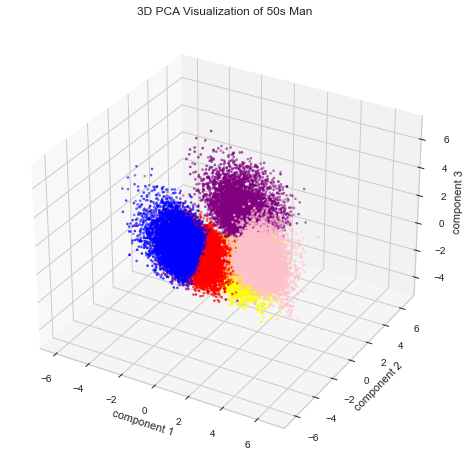

In [10]:
pca3 = PCA(n_components=3)
data_pca3 = pca3.fit_transform(scaled_data_pca_df)
pca_df = pd.DataFrame(data_pca3, columns = ['component 0', 'component 1', 'component 2'])
pca_df['target'] = data_pca_df['cluster']

# target 별 분리
pca_df_0 = pca_df[pca_df['target'] == 0]
pca_df_1 = pca_df[pca_df['target'] == 1]
pca_df_2 = pca_df[pca_df['target'] == 2]
pca_df_3 = pca_df[pca_df['target'] == 3]
pca_df_4 = pca_df[pca_df['target'] == 4]

# target 별 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df_0['component 0'], pca_df_0['component 1'], pca_df_0['component 2'], s = 5, color = 'pink', label = '0')
ax.scatter(pca_df_1['component 0'], pca_df_1['component 1'], pca_df_1['component 2'], s = 5, color = 'purple', label = '1')
ax.scatter(pca_df_2['component 0'], pca_df_2['component 1'], pca_df_2['component 2'], s = 5, color = 'yellow', label = '2')
ax.scatter(pca_df_3['component 0'], pca_df_3['component 1'], pca_df_3['component 2'], s = 5, color = 'red', label = '3')
ax.scatter(pca_df_4['component 0'], pca_df_4['component 1'], pca_df_4['component 2'], s = 5, color = 'blue', label = '4')

ax.set_title('3D PCA Visualization of 50s Man')
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.show()

* plotly를 활용한 3차원 데이터 시각화 (회전 기능사용)

In [11]:
import plotly.io as pio
pio.renderers.default='browser'
import plotly.express as px
fig = px.scatter_3d(pca_df, x='component 0', y='component 1', z='component 2',
              color='target')
fig.update_traces(marker_size = 1)
fig.show()

# 데이터 저장

In [12]:
data_man['cluster'] = clusters
data_man.to_csv('C:/Users/hyunj/Desktop/데이터마이닝 코드/Man_Clustering_Data.csv', encoding='CP949', index = False)
print(data_man['cluster'].value_counts())

0    8164
4    7467
2    6824
3    6240
1    5002
Name: cluster, dtype: int64
